# Import Library

In [1]:

from cartopy import config
import cartopy
import cartopy.crs as ccrs
import climtas
import cmocean
from collections import namedtuple
import dask.array
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind 
import seaborn as sns
import sparse
from string import ascii_lowercase
import xarray as xr


import warnings
warnings.filterwarnings("ignore")
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np

import matplotlib.pyplot as plt
import xarray as xr    
import glob
import os
import cartopy.crs as ccrs
import matplotlib.colors as colors
import pandas as pd
import datetime
from matplotlib import colors
import pymannkendall as mk
from matplotlib.ticker import MaxNLocator

from matplotlib import pyplot as plt
import numpy as np
from pandas import *


# Import Data 

In [2]:
list2=[1,2,3,4,5,6]



#DMI
d_filenames = sorted(glob.glob("/g/data/w97/sl7808/ALLOUTPUT/DMI_ACCESS/*.nc")) 

file_name = []
f=[]
for d in d_filenames:   
    
    a = xr.open_dataset(d)
    DMI_p=a.sel(time=a.time.dt.month.isin([8,9,10])) #select DMI peak months
    x=DMI_p.tos.groupby('time.year').mean(dim='time')#take the mean of each year
    z=x.rename({'year':'time'})
    del z['time']
    f.insert(-1,z)

pIOD_1=xr.concat(f, 'ensemble').isel(time=slice(0,164))
pIOD=pIOD_1

In [3]:
#New Nino3.4 calculation 17May
nino_Access_filenames = []
nino_Access_filenames = sorted(glob.glob("/g/data/w97/sl7808/Nino34/4_detrend/*.nc")) 
file_name = []
f=[]


for n in nino_Access_filenames:
    a = xr.open_dataset(n)
    
    dataout = np.empty(165,dtype=np.float64)
    start_year = 1850
    for yy in range(165):
        yr=yy+1850
        start_string = '%s-12-01' %(yr)
        end_string = '%s-02-28' %(yr+1)
        dataout[yy] = a.tos.sel(time=slice(start_string,end_string)).mean(dim='time') #sel DJF

    dm_new = xr.DataArray(
                    data   = dataout,
                    dims   = ['time'],
                    coords = {'time': np.arange(1850,2015)},
                    )
    
    sd=dm_new.sel(time=slice('1961','1990')).std(dim='time')
    nor_dm=dm_new/sd
    
    nor_dm.plot
    
    f.insert(-1,nor_dm)
    
nino=xr.concat(f, 'ensemble')
nino

<xarray.DataArray (ensemble: 20, time: 165)>
array([[-0.88225358, -0.21567213,  1.29090825, ..., -0.05340292,
         2.83334078, -1.24685577],
       [ 0.79511251, -0.29925568,  0.55478174, ...,  1.11585396,
        -0.11034973,  0.62211133],
       [-0.19218288,  0.7493613 , -0.36546519, ...,  0.28974434,
         0.32573729, -0.56657526],
       ...,
       [-1.01796375, -0.54519087,  2.19460138, ...,  0.40824488,
         0.44519929, -0.73778422],
       [ 0.57197435, -0.46572327, -0.76214227, ...,  0.18345768,
         1.3897249 ,  1.98961713],
       [-2.105748  ,  0.07455954, -2.15223142, ...,  0.71255869,
         1.58617305,  2.01969988]])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
Dimensions without coordinates: ensemble

# Define Composite pairs

In [4]:
def choose_H(pIOD_sel,nino_sel,num,p,n): 
    if num==0:#Nino+, DMI+
        HH=H.where(pIOD_sel>p).where(nino_sel>p)
        title= 'Nino+, DMI+'
        
    elif num==1: #Nino neu, DMI+
        HH=H.where(pIOD_sel>p).where(nino_sel>n).where(nino_sel<p)
        title= 'Nino neu, DMI+'
    
    elif num==2:#Nino-, DMI+
        HH=H.where(pIOD_sel>p).where(nino_sel<n)
        title='Nino-, DMI+'
        
    elif num==3: #DMI neutral, Nino +
        HH=H.where(pIOD_sel>n).where(pIOD_sel<p).where(nino_sel>p)
        title='Nino +, DMI neu'
        
    elif num==4:#Both neutral
        HH=H.where(pIOD_sel>n).where(pIOD_sel<p).where(nino_sel>n).where(nino_sel<p)
        title='Nino neu, DMI neu'        
        
        
    elif num==5:#DMI Neu, Nino -
        HH=H.where(pIOD_sel>n).where(pIOD_sel<p).where(nino_sel<n)
        title='Nino -, DMI neu'
        
        
    elif num==6:#Nino+, DMI-
        HH=H.where(pIOD_sel<n).where(nino_sel>p) 
        title='Nino+, DMI-'

    elif num==7:#DMI -, Nino Neu
        HH=H.where(pIOD_sel<n).where(nino_sel>n).where(nino_sel<p)
        title= 'Nino neu, DMI -'
        
    elif num==8:#Nino-, DMI-
        HH=H.where(pIOD_sel<n).where(nino_sel<n)
        title='Nino-, DMI-'
    return HH,title
        

# Figure 16 and 17

Run either ENSO or IOD for Figure 16 or 17

In [5]:
#ENSO
tt="ENSO"
title_list=["ENSO neu","El Nino","La Nina"]
numlist_1=[1,1,4,0,0,3,2,2,5]
numlist_2=[4,7,7,3,6,6,5,8,8]



heading_list=['a. {ENSO neu}\n[IOD+ - IODneu]','b. {ENSO neu}\n[IOD+ - IOD-]','c. {ENSO neu}\n[IODneu - IOD-]',
              'd. {El Nino}\n[IOD+ - IOD neu]','e. {El Nino}\n[IOD+ - IOD-]','f. {El Nino}\n[IODneu - IOD-]',
              'g. {La Nina}\n[IOD+ - IOD neu]','h. {La Nina}\n[IOD+ - IOD-]','i. {La Nina}\n[IODneu - IOD-]']

In [9]:
#IOD
tt="IOD"
title_list=["IOD neu","IOD +",'IOD -']
numlist_1=[3,3,4,0,0,1,6,6,7]
numlist_2=[4,5,5,1,2,2,7,8,8]
       
heading_list=['a. {IOD neu}\n[EN - ENSO neu]','b. {IOD neu}\n[EN - LN]','c. {IOD neu}\n[ENSO neu - LN]',
              'd. {IOD +}\n[EN - ENSO neu]','e. {IOD +}\n[EN - LN]','f. {IOD +}\n[ENSO neu - LN]',
              'g. {IOD -}\n[EN - ENSO neu]','h. {IOD -}\n[EN - LN]','i. {IOD -}\n[ENSO neu - LN]']

## Calculate the area with significance

In [10]:

p=1
n=-1


HWX_list =["HWF_EHF","HWD_EHF","HWT_EHF","HWC"] #one HWX in each row 
land_sea = xr.open_dataset("/g/data/w97/sl7808/landmask_accessESM1-5_AUS.nc").sftlf




p_value_list_5=[]
p_value_list_6=[]

for (h) in (HWX_list):
    print(h)
    d = ("/g/data/w97/sl7808/ALLOUTPUT/EHF_year_ACCESS/by_HWX/"+h+".nc") 
    d1=xr.open_dataset(d, decode_times=False)
    HWA=d1[h]
    p_value_list_3=[]
    p_value_list_4=[]

    for (num1, num2) in zip (numlist_1,numlist_2):
        p_value_list_1=[]
        p_value_list_2=[]



        #Composite_1
        g=[]
        ggg=[]

        for i in range(20): 
            nino_sel=nino.isel(ensemble=i)
            pIOD_sel=pIOD.isel(ensemble=i)
            H=HWA.isel(ensemble=i).where(land_sea>60)
            re_turn=choose_H(pIOD_sel,nino_sel,num1,p,n)
            H3=re_turn[0]
            g.insert(-1,H3)

        ggg_1=xr.concat(g, 'ensemble')  
        ggg_1_stacked = ggg_1.stack(ens_time=['time','ensemble'])
        ggg_1_mean=ggg_1.mean(dim=['ensemble','time'])



        #Composite_2
        g=[]
        ggg=[]

        for i in range(20): 
            nino_sel=nino.isel(ensemble=i)
            pIOD_sel=pIOD.isel(ensemble=i)
            H=HWA.isel(ensemble=i).where(land_sea>60)
            re_turn=choose_H(pIOD_sel,nino_sel,num2,p,n)
            H3=re_turn[0]
            g.insert(-1,H3)


        ggg_2=xr.concat(g, 'ensemble')  
        ggg_2_mean=ggg_2.mean(dim=['ensemble','time'])
        ggg_2_stacked = ggg_2.stack(ens_time=['time','ensemble'])


        #p-value (Composite 1 vs 2)
        r = stats.ttest_ind(ggg_1_stacked, ggg_2_stacked, axis=2, equal_var=False, nan_policy='omit')
        p_value = xr.DataArray(r[1], dims=('lat', 'lon'), 
                          coords={'lat': ggg_1['lat'],'lon': ggg_1['lon']})

        #p-value count
        c1=p_value.stack(stack_dim=['lat','lon'])#.dropna(dim='stack_dim')
        c2_org=c1.where(c1<0.05).count() #number of cells with significant difference 
        c3_org=c2_org*(100/290)
        c4_org=c3_org.round(2)
        p_value_list_3.append(float(c4_org.values))



        #diff (Composite1 - Composite2)
        ggg_diff=ggg_1_mean-ggg_2_mean
        ggg_diff_stacked=ggg_diff.stack(stack_dim=['lat','lon'])#.dropna(dim='stack_dim')

        #diff count
        c2=c1.where(c1<0.05).where(ggg_diff_stacked>0).count()
        c3=c2*(100/c2_org)
        c4=c3.round(2)
        p_value_list_4.append(float(c4.values))#number of cells with significant difference and positive difference


    p_value_list_5.append(p_value_list_3)
    p_value_list_6.append(p_value_list_4)
    
    
    
print("done")

  

HWF_EHF
HWD_EHF
HWT_EHF
HWC
done


## Plot the table

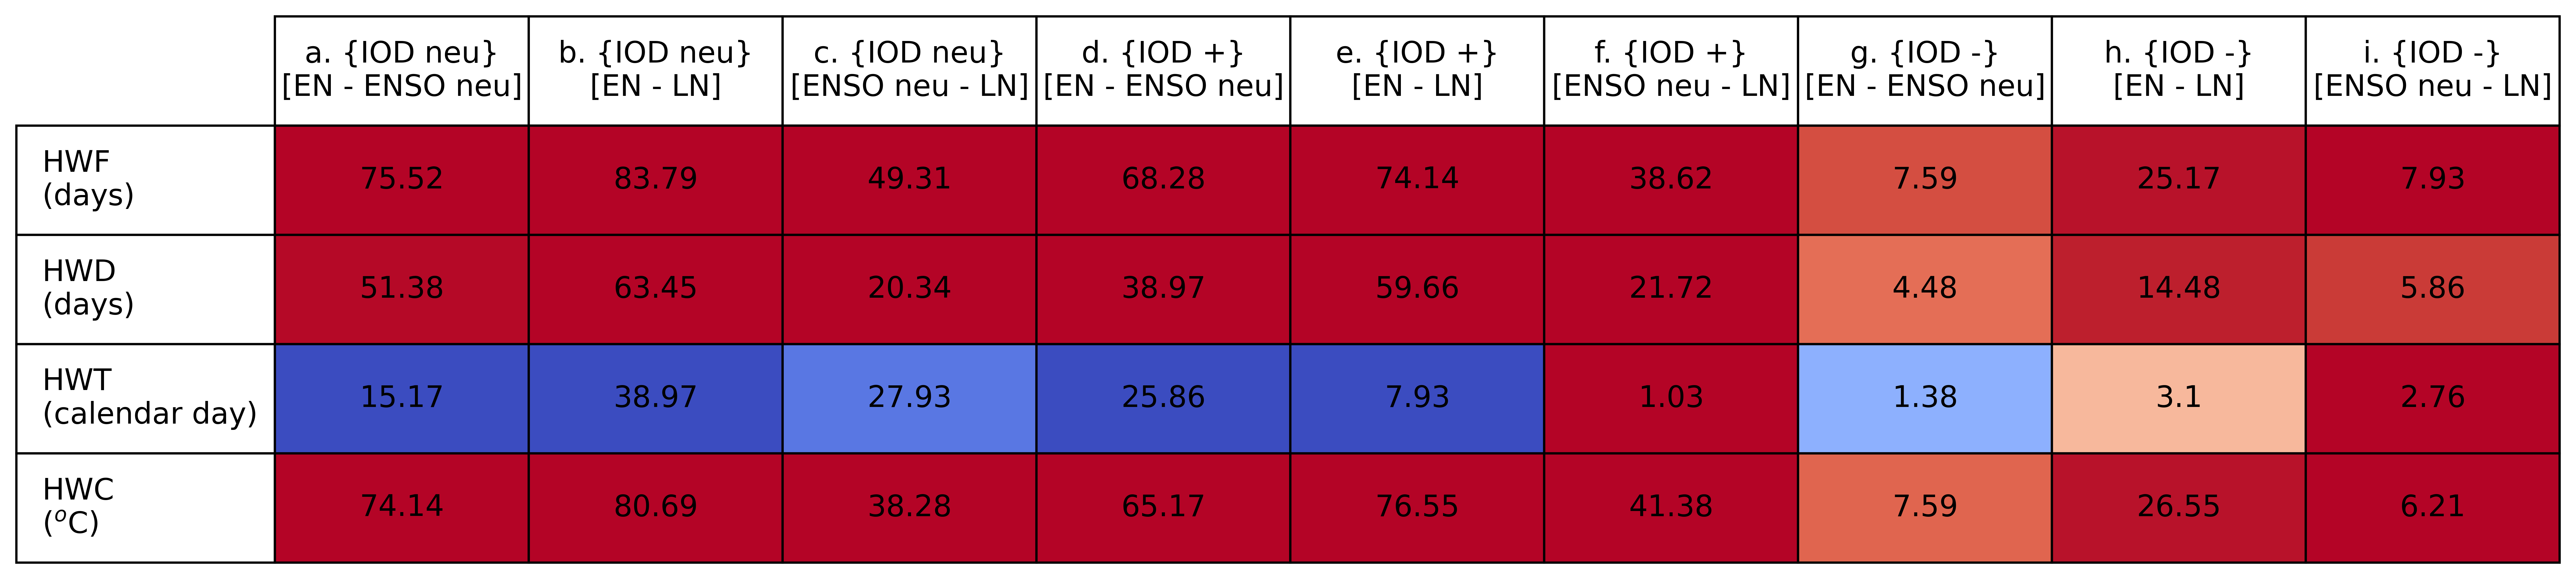

IOD


In [11]:
#table

HWX_list_2 =["HWF\n(days)","HWD\n(days)","HWT\n(calendar day)",'HWC\n($^o$C)']

vals=p_value_list_6

norm = plt.Normalize(0, 100)

fig = plt.figure(figsize=(10,3), dpi=600)
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

df = DataFrame(vals, index=HWX_list_2, columns=heading_list)
colours = plt.cm.coolwarm(norm(vals))
the_table=plt.table(cellText=p_value_list_5, rowLabels=df.index, colLabels=df.columns, 
                colWidths = [.2]*9, loc='center',  cellLoc='center',
                cellColours=colours)

the_table.auto_set_font_size(False)
the_table.set_fontsize(13)
the_table.scale(1, 4)


plt.show()

print(tt)

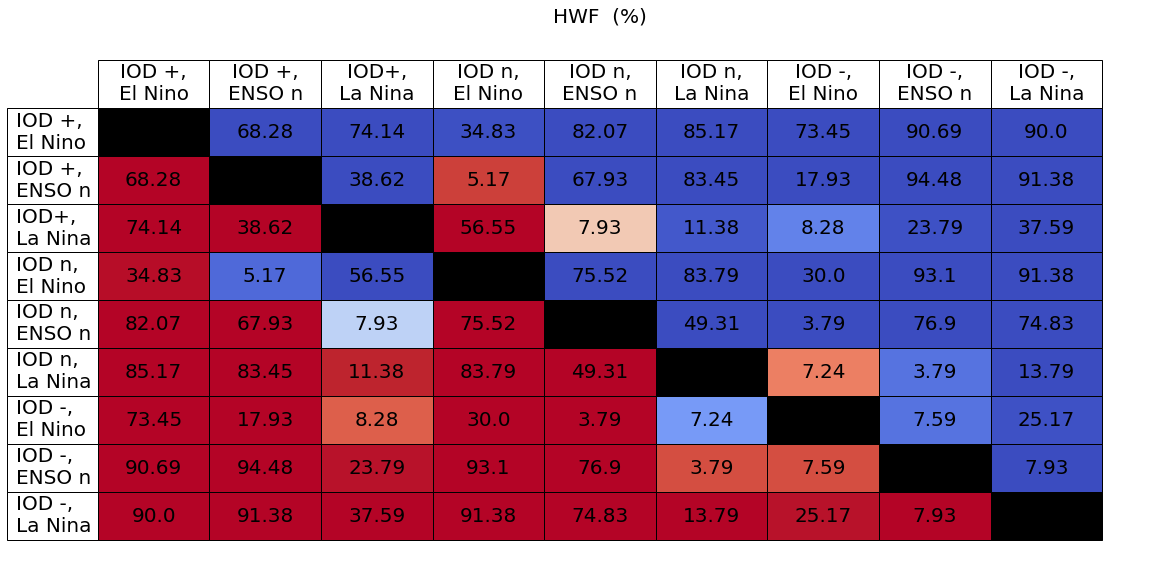

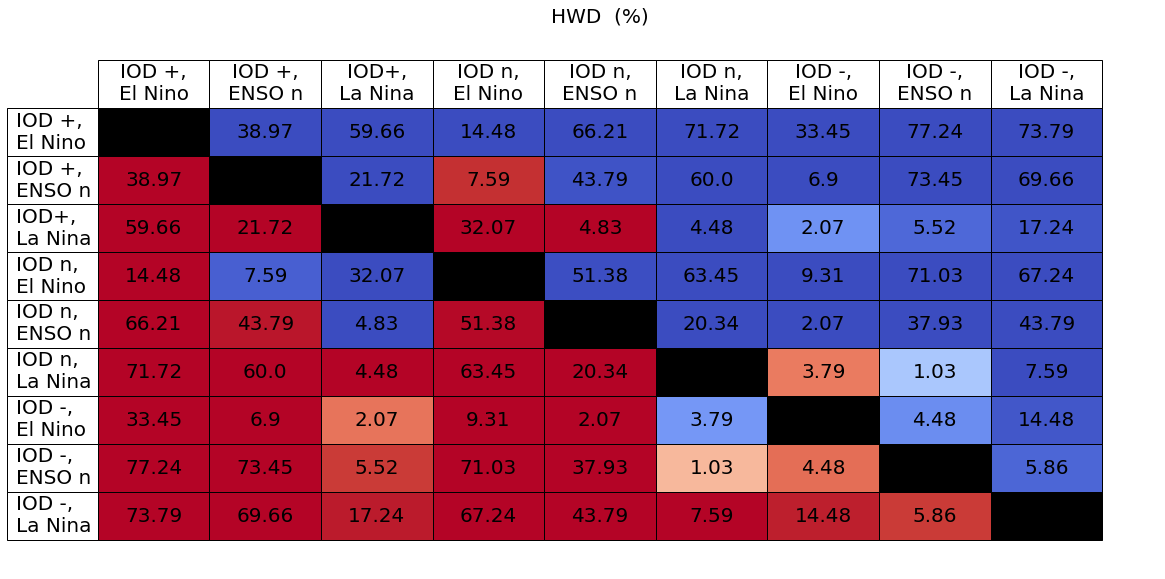

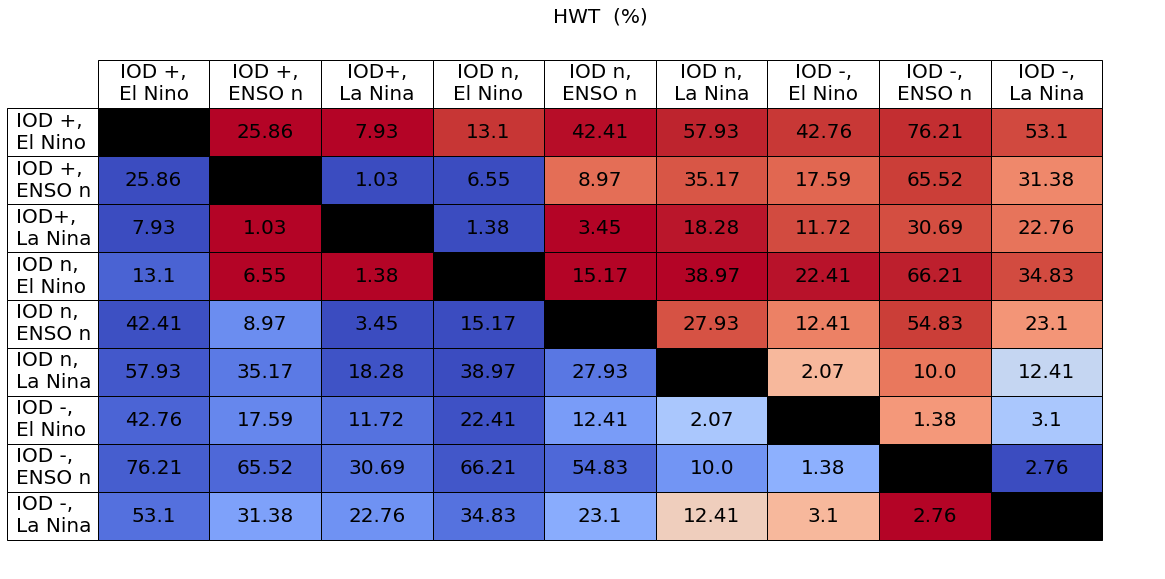

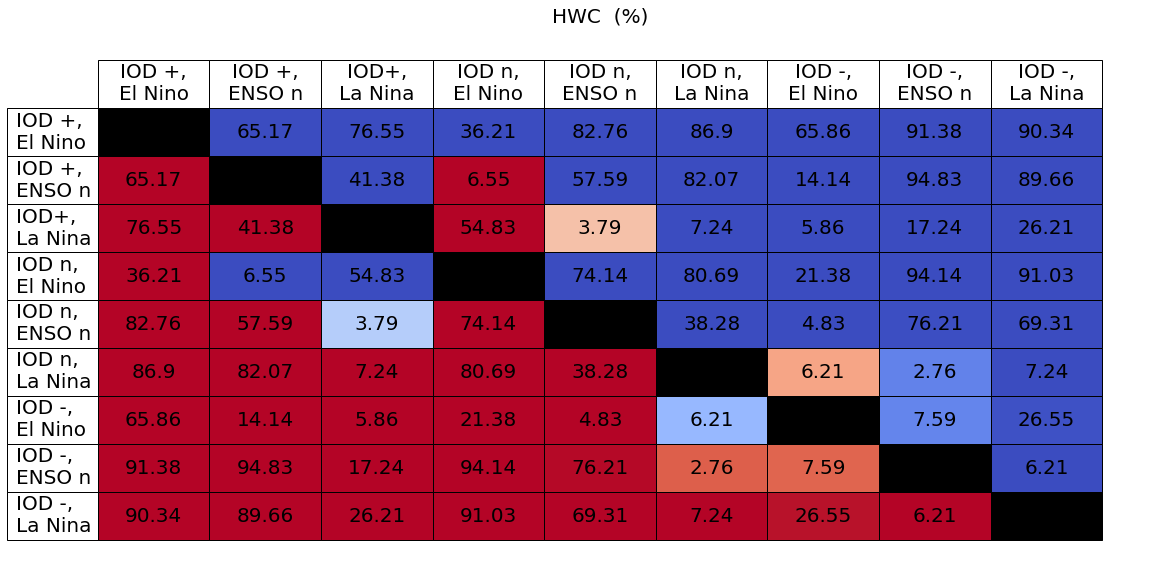

In [19]:

p=1
n=-1


HWX_list =["HWF_EHF","HWD_EHF","HWT_EHF","HWC"]
HWX_list_2 =["HWF","HWD","HWT",'HWC']

land_sea = xr.open_dataset("/g/data/w97/sl7808/landmask_accessESM1-5_AUS.nc").sftlf




for (h,h2) in zip (HWX_list,HWX_list_2):
    #HWX
    
    d = ("/g/data/w97/sl7808/ALLOUTPUT/EHF_year_ACCESS/by_HWX/"+h+".nc") 
    d1=xr.open_dataset(d, decode_times=False)
    HWA=d1[h]
    p_value_list_2=[]
    p_value_list_4=[]
    
    #target
    for nnn in range(9):

        g=[]
        ggg=[]
        for i in range(20): 
            nino_sel=nino.isel(ensemble=i)
            pIOD_sel=pIOD.isel(ensemble=i)
            H=HWA.isel(ensemble=i).where(land_sea>60)
            re_turn=choose_H(pIOD_sel,nino_sel,nnn,p,n)
            H3=re_turn[0]
            g.insert(-1,H3)

        ggg_tar=xr.concat(g, 'ensemble')  
        ggg_tar_stacked = ggg_tar.stack(ens_time=['time','ensemble'])
        ggg_tar_mean=ggg_tar.mean(dim=['ensemble','time'])



        #plot the rest
        g=[]
        ggg=[]
        num=0
        c=0
        p_value_list=[]
        p_value_list_3=[]
        
        for k in range(9):
                  
            g=[]
            ggg=[]
            for i in range(20): 
                nino_sel=nino.isel(ensemble=i)
                pIOD_sel=pIOD.isel(ensemble=i)
                H=HWA.isel(ensemble=i).where(land_sea>60)
                re_turn=choose_H(pIOD_sel,nino_sel,num,p,n)
                H3=re_turn[0]
                g.insert(-1,H3)


            ggg=xr.concat(g, 'ensemble')  
            ggg_mean=ggg.mean(dim=['ensemble','time'])
            ggg_stacked = ggg.stack(ens_time=['time','ensemble'])
            
            
            #p-value
            r = stats.ttest_ind(ggg_stacked, ggg_tar_stacked, axis=2, equal_var=False, nan_policy='omit')
            p_value = xr.DataArray(r[1], dims=('lat', 'lon'), 
                              coords={'lat': ggg['lat'],'lon': ggg['lon']})
                      
            c1=p_value.stack(stack_dim=['lat','lon'])#.dropna(dim='stack_dim')
            c2_org=c1.where(c1<0.05).count() #number of cells with significant difference 
            
            
            #diff
            ggg_diff=ggg_mean-ggg_tar_mean
            ggg_diff_stacked=ggg_diff.stack(stack_dim=['lat','lon'])#.dropna(dim='stack_dim')
            
            #count
            c2=c1.where(c1<0.05).where(ggg_diff_stacked>0).count()
            c3=c2*(100/c2_org)
            c4=c3.round(2)
            p_value_list.append(float(c4.values))

            c=c+c4
            
            
            
            c3_org=c2_org*(100/290)
            c4_org=c3_org.round(2)
            p_value_list_3.append(float(c4_org.values))

            
            num=num+1
        
            

        p_value_list_2.append(p_value_list)
        p_value_list_4.append(p_value_list_3)
        


    vals=p_value_list_2
    
    
    heading=["IOD +,\nEl Nino","IOD +,\nENSO n","IOD+,\nLa Nina","IOD n,\nEl Nino","IOD n,\nENSO n","IOD n,\nLa Nina","IOD -,\nEl Nino","IOD -,\nENSO n","IOD -,\nLa Nina"]


    norm = plt.Normalize(0, 100)

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

    df = DataFrame(vals, index=heading, columns=heading)
    colours = plt.cm.coolwarm(norm(vals))
    the_table=plt.table(cellText=p_value_list_4, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], loc='center',  cellLoc='center',
                    cellColours=colours)

    for c in range(9): 
        b=c+1
        the_table[(b, c)].set_facecolor("k")
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(20)
    the_table.scale(1, 4)
    plt.title(h2+'  (%)',fontsize=20)
    plt.show()
    
    

    
    
    
